# Forecasting Series Tiempo

**Objetivo:**:  Mejorar la toma de decisiones, optimizar recursos y brindar una experiencia superior a los clientes.

**Necesidad:** Anticipar las ventas de los próximos 30 días para evitar problemas de inventario.

**Problema a resolver:** ¿Cómo anticipar las ventas futuras para tomar decisiones acertadas sobre inventarios y recursos, reduciendo el impacto de los períodos de alta y baja demanda?

In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [47]:
DATA_PATH = os.path.join('..', '..', 'data', 'input', 'forecasting')
data = pd.read_csv(os.path.join(DATA_PATH, 'data_processed.csv'))

In [48]:
# Convert weekly data to daily using linear interpolation
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate sales across all stores and departments
df = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Create daily dates
daily_dates = pd.date_range(df['Date'].min(), df['Date'].max(), freq='D')
daily_df = pd.DataFrame({'Date': daily_dates})

# Merge with original data
daily_df = daily_df.merge(df, on='Date', how='left')

# Interpolate missing values
daily_df['Weekly_Sales'] = daily_df['Weekly_Sales'].interpolate(method='linear')


In [49]:
daily_df

,Date,Weekly_Sales
0,2010-02-05,49750875.98
1,2010-02-06,49548865.14
2,2010-02-07,49346854.30
3,2010-02-08,49144843.46
4,2010-02-09,48942832.62
...,...,...
990,2012-10-22,45303273.49
991,2012-10-23,45363550.00
992,2012-10-24,45423826.51
993,2012-10-25,45484103.02


## Modelado

### SARIMA

Comencemos utilizando el modelo SARIMA, es una extensión del modelo ARIMA que permite capturar patrones estacionales en series temporales.

Utilizaremos los siguientes parámetros:

1. Parámetros del orden no estacional (p, d, q)
- p = 1 (AR): El componente autoregresivo considera el valor previo de la serie temporal para hacer predicciones. Esto indica que la relación entre el valor actual y el anterior tiene influencia significativa.
- d = 1 (I): Se diferencia la serie una vez para hacerla estacionaria, lo cual se evidenció necesario dado el resultado de la prueba de Dickey-Fuller.
- q = 1 (MA): Se incluye un componente de media móvil de orden 1 para modelar la dependencia entre el valor actual y el error aleatorio previo.

2. Parámetros del orden estacional (P, D, Q, s)
- P = 1 (AR estacional): El valor actual de la serie está relacionado con el mismo período de tiempo en temporadas anteriores.
- D = 1 (diferenciación estacional): Se realiza una diferenciación estacional para eliminar tendencias estacionales persistentes.
- Q = 1 (MA estacional): Se modela el componente de media móvil estacional.
- s = 52 (periodicidad): La periodicidad de 52 semanas se selecciona porque los datos tienen una frecuencia semanal y se observó una estacionalidad anual.

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar SARIMA
model = SARIMAX(daily_df['Weekly_Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
result = model.fit()
print(result.summary())


d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_3\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  995
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood              -14333.426
Date:                            Thu, 20 Feb 2025   AIC                          28676.852
Time:                                    13:51:58   BIC                          28701.092
Sample:                                         0   HQIC                         28686.092
                                            - 995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6377      0.012     51.681      0.000       0.614       0.662
ma.L1         -0.3719      0.012   

In [55]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Separación en train-test
train = daily_df["Weekly_Sales"].iloc[:-30]
test = daily_df["Weekly_Sales"].iloc[-30:]

# Evaluación de SARIMA
forecast_sarima = result.get_forecast(steps=30).predicted_mean
rmse = root_mean_squared_error(test, forecast_sarima)
mae = mean_absolute_error(test, forecast_sarima)
mape = mean_absolute_percentage_error(test, forecast_sarima)
print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")


RMSE: 3314036.653283684, MAE: 3037845.1679471047, MAPE: 0.06603708874116612


### Modelo de RNN y LSTM

Lo primero es normalizar los datos y convertir la serie en secuencias que la red pueda procesar.

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = os.path.join('..', '..', 'data', 'input', 'forecasting')
data = pd.read_csv(os.path.join(DATA_PATH, 'data_processed.csv'))

In [132]:
def prepare_data(df):
	# Convert weekly data to daily using linear interpolation
	df = df.copy()
	df['Date'] = pd.to_datetime(df['Date'])
	
	# Aggregate sales across all stores and departments
	df = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
	
	# Create daily dates
	daily_dates = pd.date_range(df['Date'].min(), df['Date'].max(), freq='D')
	daily_df = pd.DataFrame({'Date': daily_dates})
	
	# Merge with original data
	daily_df = daily_df.merge(df, on='Date', how='left')
	
	# Interpolate missing values
	daily_df['Weekly_Sales'] = daily_df['Weekly_Sales'].interpolate(method='linear')
	
	# Add time-based features
	# daily_df['DayOfWeek'] = daily_df['Date'].dt.dayofweek
	# daily_df['Month'] = daily_df['Date'].dt.month
	# daily_df['Year'] = daily_df['Date'].dt.year
	# daily_df['DayOfYear'] = daily_df['Date'].dt.dayofyear
	# daily_df['IsWeekend'] = daily_df['DayOfWeek'].isin([5, 6]).astype(int)
	
	return daily_df

In [138]:
def prepare_features(df, scaler):
	# Create feature matrix
    feature_columns = [
		'Weekly_Sales', 
		# 'DayOfWeek', 'Month', 'Year','DayOfYear', 'IsWeekend'
	]
	
    scaled_features = scaler.transform(df[feature_columns])
	
    return scaled_features

In [135]:
def create_sequences(data, seq_length=30):
	"""Create sequences without fixed prediction length"""
	X = []
	for i in range(len(data) - seq_length + 1):
		X.append(data[i:(i + seq_length)])
	return np.array(X)

In [136]:
daily_df = prepare_data(data)
daily_df

,Date,Weekly_Sales
0,2010-02-05,49750875.98
1,2010-02-06,49548865.14
2,2010-02-07,49346854.30
3,2010-02-08,49144843.46
4,2010-02-09,48942832.62
...,...,...
990,2012-10-22,45303273.49
991,2012-10-23,45363550.00
992,2012-10-24,45423826.51
993,2012-10-25,45484103.02


In [139]:
scaler = MinMaxScaler().fit(daily_df[['Weekly_Sales']])
scaled_features = prepare_features(daily_df, scaler)
scaled_features

array([[0.24558922],
       [0.24070161],
       [0.235814  ],
       [0.23092639],
       [0.22603878],
       [0.22115117],
       [0.21626356],
       [0.21137595],
       [0.21117237],
       [0.2109688 ],
       [0.21076522],
       [0.21056165],
       [0.21035808],
       [0.2101545 ],
       [0.20995093],
       [0.19506262],
       [0.18017432],
       [0.16528601],
       [0.15039771],
       [0.1355094 ],
       [0.1206211 ],
       [0.10573279],
       [0.11576421],
       [0.12579563],
       [0.13582705],
       [0.14585846],
       [0.15588988],
       [0.1659213 ],
       [0.17595272],
       [0.1726834 ],
       [0.16941408],
       [0.16614477],
       [0.16287545],
       [0.15960613],
       [0.15633681],
       [0.1530675 ],
       [0.14982743],
       [0.14658737],
       [0.14334731],
       [0.14010725],
       [0.13686718],
       [0.13362712],
       [0.13038706],
       [0.12743236],
       [0.12447767],
       [0.12152297],
       [0.11856828],
       [0.115

In [140]:
seq_length = 30
pred_length = 30

In [141]:
# Create sequences
X = create_sequences(scaled_features, seq_length)
y = scaled_features[seq_length:, 0]

In [142]:
# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size-pred_length:train_size]

Ahora, usemos una arquitectura sencilla para comenzar.

In [143]:
# Definir el modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mse')


d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_3\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [144]:
# Entrenar el modelo, manteniendo los mejores pesos
checkpoint = ModelCheckpoint('../../models/forecasting/model1.keras', save_best_only=True)
history = model.fit(X_train, y_train, epochs=300, batch_size=48, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0196 - val_loss: 0.0226
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0084 - val_loss: 0.0196
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0067 - val_loss: 0.0190
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0061 - val_loss: 0.0164
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0065 - val_loss: 0.0177
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0067 - val_loss: 0.0140
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0044 - val_loss: 0.0139
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0062 - val_loss: 0.0120
Epoch 9/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0042 - val_loss: 0.0114
Epoch 10/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0043 - val_loss: 0.0103
Epoch 11/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040 - val_loss: 0.0098
Epoch 12/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

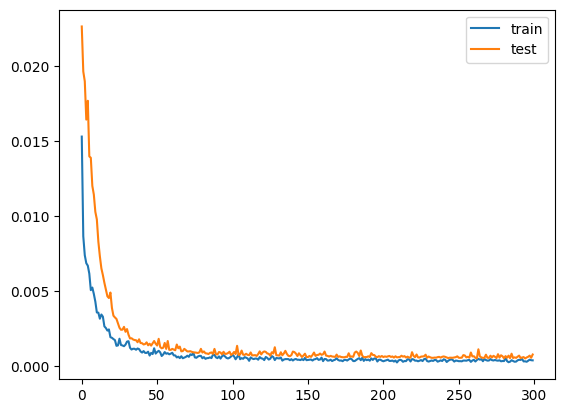

In [145]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [147]:
def recursive_predict(model, initial_sequence, n_steps, future_features, scaler):
    """
    Realiza predicciones recursivas utilizando un modelo de series temporales.
    
    Args:
        model: Modelo entrenado
        initial_sequence: Secuencia inicial de entrada (shape: [sequence_length, n_features])
        n_steps: Número de pasos futuros a predecir
        future_features: Características futuras conocidas
    
    Returns:
        np.array: Array con las predicciones
    """
    predictions = []
    current_sequence = initial_sequence.copy()
    
    for i in range(n_steps):
        # Realizar predicción
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape))[0]
        predictions.append(next_pred)
        
        # Actualizar la secuencia
        current_sequence = np.roll(current_sequence, -1, axis=0)
        
        # Actualizar el último valor con la predicción
        current_sequence[-1, 0] = next_pred
        
        # Actualizar características temporales si están disponibles
        if i < len(future_features):
            current_sequence[-1, 1:] = future_features[i, 1:]  # Mantener todas las características excepto weekly_sales
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [148]:
# Make predictions
initial_sequence = X_test[0]
y_pred = recursive_predict(
    model,
    initial_sequence,
    pred_length,
    scaled_features[train_size:train_size+pred_length],
    scaler
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Users\alexg\AppData\Local\Temp\ipykernel_10208\2867808645.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1, 0] = next_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [149]:
# Métricas
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae = mean_absolute_error(y_test_inv, y_pred)
mape = mean_absolute_percentage_error(y_test_inv, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

RMSE: 2806386.5589025402, MAE: 2250273.2362380964, MAPE: 0.04620979503614588


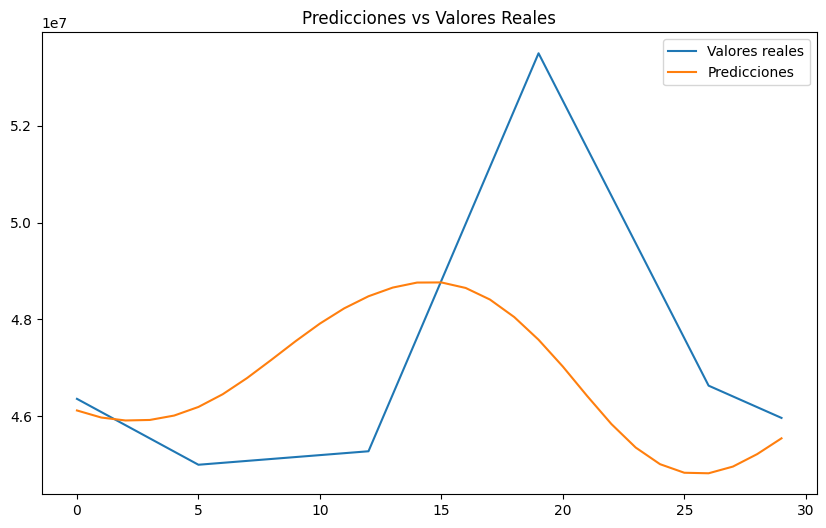

In [150]:
# Gráfico de predicciones vs reales
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Valores reales')
plt.plot(y_pred, label='Predicciones')
plt.legend()
plt.title("Predicciones vs Valores Reales")
plt.show()

### Segundo modelo usando RNN y LSTM

In [151]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [152]:
DATA_PATH = os.path.join('..', '..', 'data', 'input', 'forecasting')
data = pd.read_csv(os.path.join(DATA_PATH, 'data_processed.csv'))

In [153]:
def prepare_data(df):
	# Convert weekly data to daily using linear interpolation
	df = df.copy()
	df['Date'] = pd.to_datetime(df['Date'])
	
	# Aggregate sales across all stores and departments
	df = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
	
	# Create daily dates
	daily_dates = pd.date_range(df['Date'].min(), df['Date'].max(), freq='D')
	daily_df = pd.DataFrame({'Date': daily_dates})
	
	# Merge with original data
	daily_df = daily_df.merge(df, on='Date', how='left')
	
	# Interpolate missing values
	daily_df['Weekly_Sales'] = daily_df['Weekly_Sales'].interpolate(method='linear')
	
	# Add time-based features
	# daily_df['DayOfWeek'] = daily_df['Date'].dt.dayofweek
	# daily_df['Month'] = daily_df['Date'].dt.month
	# daily_df['Year'] = daily_df['Date'].dt.year
	# daily_df['DayOfYear'] = daily_df['Date'].dt.dayofyear
	# daily_df['IsWeekend'] = daily_df['DayOfWeek'].isin([5, 6]).astype(int)
	
	return daily_df

In [154]:
def prepare_features(df, scaler):
	# Create feature matrix
    feature_columns = [
		'Weekly_Sales', 
		# 'DayOfWeek', 'Month', 'Year','DayOfYear', 'IsWeekend'
	]
	
    scaled_features = scaler.transform(df[feature_columns])
	
    return scaled_features

In [155]:
def create_sequences(data, seq_length=30):
	"""Create sequences without fixed prediction length"""
	X = []
	for i in range(len(data) - seq_length + 1):
		X.append(data[i:(i + seq_length)])
	return np.array(X)

In [156]:
daily_df = prepare_data(data)
daily_df

,Date,Weekly_Sales
0,2010-02-05,49750875.98
1,2010-02-06,49548865.14
2,2010-02-07,49346854.30
3,2010-02-08,49144843.46
4,2010-02-09,48942832.62
...,...,...
990,2012-10-22,45303273.49
991,2012-10-23,45363550.00
992,2012-10-24,45423826.51
993,2012-10-25,45484103.02


In [157]:
scaler = MinMaxScaler().fit(daily_df[['Weekly_Sales']])
scaled_features = prepare_features(daily_df, scaler)
scaled_features

array([[0.24558922],
       [0.24070161],
       [0.235814  ],
       [0.23092639],
       [0.22603878],
       [0.22115117],
       [0.21626356],
       [0.21137595],
       [0.21117237],
       [0.2109688 ],
       [0.21076522],
       [0.21056165],
       [0.21035808],
       [0.2101545 ],
       [0.20995093],
       [0.19506262],
       [0.18017432],
       [0.16528601],
       [0.15039771],
       [0.1355094 ],
       [0.1206211 ],
       [0.10573279],
       [0.11576421],
       [0.12579563],
       [0.13582705],
       [0.14585846],
       [0.15588988],
       [0.1659213 ],
       [0.17595272],
       [0.1726834 ],
       [0.16941408],
       [0.16614477],
       [0.16287545],
       [0.15960613],
       [0.15633681],
       [0.1530675 ],
       [0.14982743],
       [0.14658737],
       [0.14334731],
       [0.14010725],
       [0.13686718],
       [0.13362712],
       [0.13038706],
       [0.12743236],
       [0.12447767],
       [0.12152297],
       [0.11856828],
       [0.115

In [158]:
seq_length = 30
pred_length = 30

In [159]:
# Create sequences
X = create_sequences(scaled_features, seq_length)
y = scaled_features[seq_length:, 0]

In [160]:
# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size-pred_length:train_size]

In [161]:
# Modelo LSTM
model2 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model2.compile(optimizer='adam', loss='mse')


d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_3\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [162]:
checkpoint = ModelCheckpoint('../../models/forecasting/model2.keras', save_best_only=True)

history2 = model2.fit(
    X_train, y_train,
    epochs=300,
    batch_size=48,
    validation_split=0.2,
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0227 - val_loss: 0.0320
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0090 - val_loss: 0.0230
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0059 - val_loss: 0.0204
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0081 - val_loss: 0.0191
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0089 - val_loss: 0.0188
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0063 - val_loss: 0.0151
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0062 - val_loss: 0.0129
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0049 - val_loss: 0.0133
Epoch 9/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0044 - val_loss: 0.0118
Epoch 10/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0040 - val_loss: 0.0101
Epoch 11/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0031 - val_loss: 0.0076
Epoch 12/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

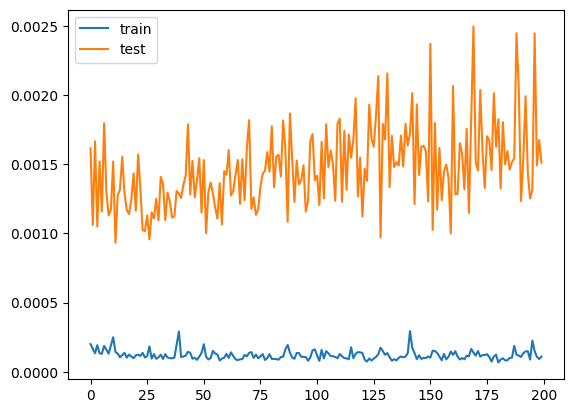

In [122]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

In [163]:
def recursive_predict(model, initial_sequence, n_steps, future_features, scaler):
    """
    Realiza predicciones recursivas utilizando un modelo de series temporales.
    
    Args:
        model: Modelo entrenado
        initial_sequence: Secuencia inicial de entrada (shape: [sequence_length, n_features])
        n_steps: Número de pasos futuros a predecir
        future_features: Características futuras conocidas
    
    Returns:
        np.array: Array con las predicciones
    """
    predictions = []
    current_sequence = initial_sequence.copy()
    
    for i in range(n_steps):
        # Realizar predicción
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape))[0]
        predictions.append(next_pred)
        
        # Actualizar la secuencia
        current_sequence = np.roll(current_sequence, -1, axis=0)
        
        # Actualizar el último valor con la predicción
        current_sequence[-1, 0] = next_pred
        
        # Actualizar características temporales si están disponibles
        if i < len(future_features):
            current_sequence[-1, 1:] = future_features[i, 1:]  # Mantener todas las características excepto weekly_sales
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [164]:
# Make predictions
initial_sequence = X_test[0]
y_pred2 = recursive_predict(
    model2,
    initial_sequence,
    pred_length,
    scaled_features[train_size:train_size+pred_length],
    scaler
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\alexg\AppData\Local\Temp\ipykernel_10208\2867808645.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1, 0] = next_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [165]:
# Métricas
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred2))
mae = mean_absolute_error(y_test_inv, y_pred2)
mape = mean_absolute_percentage_error(y_test_inv, y_pred2)
print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

RMSE: 7062615.93910448, MAE: 6183858.4443333335, MAPE: 0.12705812981747114


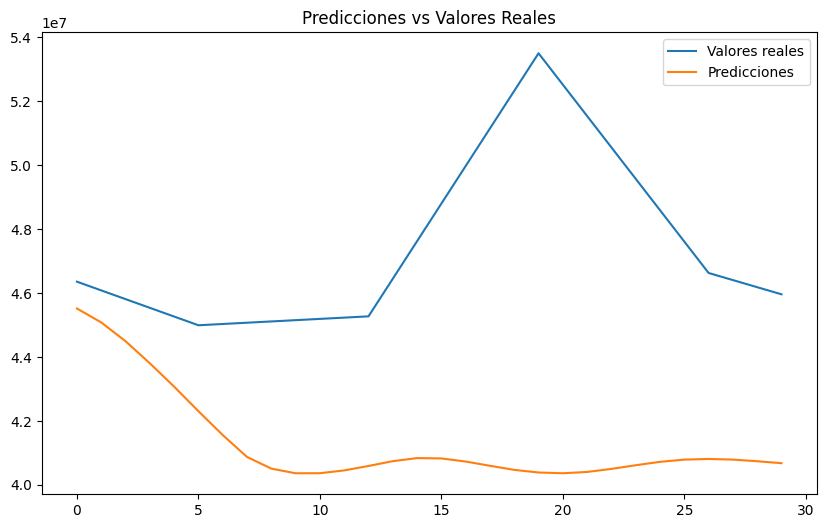

In [166]:
# Gráfico de predicciones vs reales
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Valores reales')
plt.plot(y_pred2, label='Predicciones')
plt.legend()
plt.title("Predicciones vs Valores Reales")
plt.show()

### Tercer modelo usando RNN LSTM y GRU

In [167]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [168]:
DATA_PATH = os.path.join('..', '..', 'data', 'input', 'forecasting')
data = pd.read_csv(os.path.join(DATA_PATH, 'data_processed.csv'))

In [169]:
def prepare_data(df):
	# Convert weekly data to daily using linear interpolation
	df = df.copy()
	df['Date'] = pd.to_datetime(df['Date'])
	
	# Aggregate sales across all stores and departments
	df = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
	
	# Create daily dates
	daily_dates = pd.date_range(df['Date'].min(), df['Date'].max(), freq='D')
	daily_df = pd.DataFrame({'Date': daily_dates})
	
	# Merge with original data
	daily_df = daily_df.merge(df, on='Date', how='left')
	
	# Interpolate missing values
	daily_df['Weekly_Sales'] = daily_df['Weekly_Sales'].interpolate(method='linear')
	
	# Add time-based features
	# daily_df['DayOfWeek'] = daily_df['Date'].dt.dayofweek
	# daily_df['Month'] = daily_df['Date'].dt.month
	# daily_df['Year'] = daily_df['Date'].dt.year
	# daily_df['DayOfYear'] = daily_df['Date'].dt.dayofyear
	# daily_df['IsWeekend'] = daily_df['DayOfWeek'].isin([5, 6]).astype(int)
	
	return daily_df

In [170]:
def prepare_features(df, scaler):
	# Create feature matrix
    feature_columns = [
		'Weekly_Sales', 
		# 'DayOfWeek', 'Month', 'Year','DayOfYear', 'IsWeekend'
	]
	
    scaled_features = scaler.transform(df[feature_columns])
	
    return scaled_features

In [171]:
def create_sequences(data, seq_length=30):
	"""Create sequences without fixed prediction length"""
	X = []
	for i in range(len(data) - seq_length + 1):
		X.append(data[i:(i + seq_length)])
	return np.array(X)

In [172]:
daily_df = prepare_data(data)
daily_df

,Date,Weekly_Sales
0,2010-02-05,49750875.98
1,2010-02-06,49548865.14
2,2010-02-07,49346854.30
3,2010-02-08,49144843.46
4,2010-02-09,48942832.62
...,...,...
990,2012-10-22,45303273.49
991,2012-10-23,45363550.00
992,2012-10-24,45423826.51
993,2012-10-25,45484103.02


In [173]:
scaler = MinMaxScaler().fit(daily_df[['Weekly_Sales']])
scaled_features = prepare_features(daily_df, scaler)
scaled_features

array([[0.24558922],
       [0.24070161],
       [0.235814  ],
       [0.23092639],
       [0.22603878],
       [0.22115117],
       [0.21626356],
       [0.21137595],
       [0.21117237],
       [0.2109688 ],
       [0.21076522],
       [0.21056165],
       [0.21035808],
       [0.2101545 ],
       [0.20995093],
       [0.19506262],
       [0.18017432],
       [0.16528601],
       [0.15039771],
       [0.1355094 ],
       [0.1206211 ],
       [0.10573279],
       [0.11576421],
       [0.12579563],
       [0.13582705],
       [0.14585846],
       [0.15588988],
       [0.1659213 ],
       [0.17595272],
       [0.1726834 ],
       [0.16941408],
       [0.16614477],
       [0.16287545],
       [0.15960613],
       [0.15633681],
       [0.1530675 ],
       [0.14982743],
       [0.14658737],
       [0.14334731],
       [0.14010725],
       [0.13686718],
       [0.13362712],
       [0.13038706],
       [0.12743236],
       [0.12447767],
       [0.12152297],
       [0.11856828],
       [0.115

In [174]:
seq_length = 30
pred_length = 30

In [175]:
# Create sequences
X = create_sequences(scaled_features, seq_length)
y = scaled_features[seq_length:, 0]

In [176]:
# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size-pred_length:train_size]

In [177]:
model3 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    GRU(64, return_sequences=True),
    Dropout(0.1),
    LSTM(32, return_sequences=False),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(1)
])

model3.compile(optimizer='adam', loss='mse')

d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_3\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [179]:
checkpoint = ModelCheckpoint('../../models/forecasting/model3.keras', save_best_only=True)
history3 = model3.fit(
    X_train, y_train,
    epochs=300,
    batch_size=48,
    validation_split=0.2,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0036 - val_loss: 0.0086
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0026 - val_loss: 0.0057
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0020 - val_loss: 0.0049
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.3018e-04 - val_loss: 0.0021
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.2682e-04 - val_loss: 0.0026
Epoch 9/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 10/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.8853e-04 - val_loss: 0.0021
Epoch 11/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 12/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 

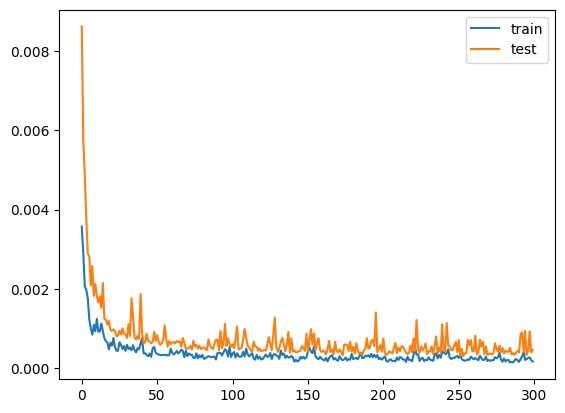

In [180]:
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.legend()
plt.show()

In [185]:
def recursive_predict(model, initial_sequence, n_steps, future_features, scaler):
    """
    Realiza predicciones recursivas utilizando un modelo de series temporales.
    
    Args:
        model: Modelo entrenado
        initial_sequence: Secuencia inicial de entrada (shape: [sequence_length, n_features])
        n_steps: Número de pasos futuros a predecir
        future_features: Características futuras conocidas
    
    Returns:
        np.array: Array con las predicciones
    """
    predictions = []
    current_sequence = initial_sequence.copy()
    
    for i in range(n_steps):
        # Realizar predicción
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape))[0]
        predictions.append(next_pred)
        
        # Actualizar la secuencia
        current_sequence = np.roll(current_sequence, -1, axis=0)
        
        # Actualizar el último valor con la predicción
        current_sequence[-1, 0] = next_pred
        
        # Actualizar características temporales si están disponibles
        if i < len(future_features):
            current_sequence[-1, 1:] = future_features[i, 1:]  # Mantener todas las características excepto weekly_sales
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [186]:
# Make predictions
initial_sequence = X_test[0]
y_pred3 = recursive_predict(
    model3,
    initial_sequence,
    pred_length,
    scaled_features[train_size:train_size+pred_length],
    scaler
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\alexg\AppData\Local\Temp\ipykernel_10208\2867808645.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1, 0] = next_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [187]:
# Métricas
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred3))
mae = mean_absolute_error(y_test_inv, y_pred3)
mape = mean_absolute_percentage_error(y_test_inv, y_pred3)
print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

RMSE: 5004788.138209439, MAE: 3953443.644333333, MAPE: 0.08013834232157205


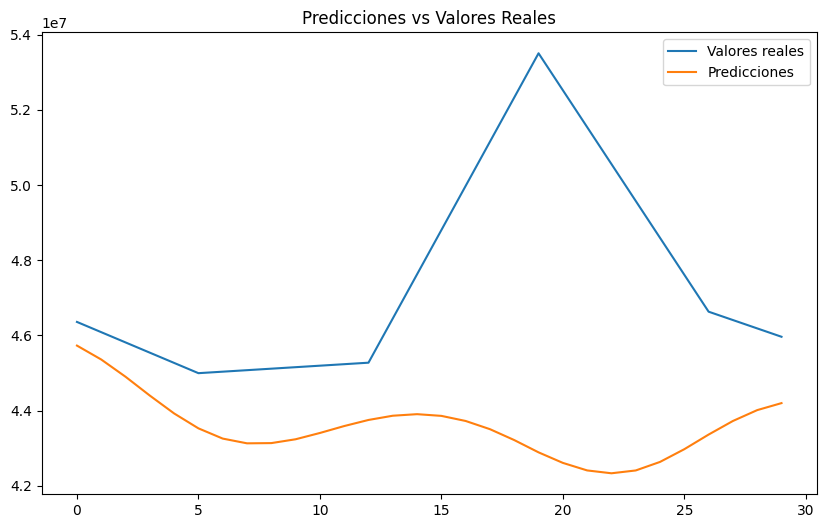

In [188]:
# Gráfico de predicciones vs reales
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Valores reales')
plt.plot(y_pred3, label='Predicciones')
plt.legend()
plt.title("Predicciones vs Valores Reales")
plt.show()

### Cuarto modelo

In [189]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [190]:
DATA_PATH = os.path.join('..', '..', 'data', 'input', 'forecasting')
data = pd.read_csv(os.path.join(DATA_PATH, 'data_processed.csv'))

In [191]:
def prepare_data(df):
	# Convert weekly data to daily using linear interpolation
	df = df.copy()
	df['Date'] = pd.to_datetime(df['Date'])
	
	# Aggregate sales across all stores and departments
	df = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
	
	# Create daily dates
	daily_dates = pd.date_range(df['Date'].min(), df['Date'].max(), freq='D')
	daily_df = pd.DataFrame({'Date': daily_dates})
	
	# Merge with original data
	daily_df = daily_df.merge(df, on='Date', how='left')
	
	# Interpolate missing values
	daily_df['Weekly_Sales'] = daily_df['Weekly_Sales'].interpolate(method='linear')
	
	# Add time-based features
	# daily_df['DayOfWeek'] = daily_df['Date'].dt.dayofweek
	# daily_df['Month'] = daily_df['Date'].dt.month
	# daily_df['Year'] = daily_df['Date'].dt.year
	# daily_df['DayOfYear'] = daily_df['Date'].dt.dayofyear
	# daily_df['IsWeekend'] = daily_df['DayOfWeek'].isin([5, 6]).astype(int)
	
	return daily_df

In [192]:
def prepare_features(df, scaler):
	# Create feature matrix
    feature_columns = [
		'Weekly_Sales', 
		# 'DayOfWeek', 'Month', 'Year','DayOfYear', 'IsWeekend'
	]
	
    scaled_features = scaler.transform(df[feature_columns])
	
    return scaled_features

In [193]:
def create_sequences(data, seq_length=30):
	"""Create sequences without fixed prediction length"""
	X = []
	for i in range(len(data) - seq_length + 1):
		X.append(data[i:(i + seq_length)])
	return np.array(X)

In [194]:
daily_df = prepare_data(data)
daily_df

,Date,Weekly_Sales
0,2010-02-05,49750875.98
1,2010-02-06,49548865.14
2,2010-02-07,49346854.30
3,2010-02-08,49144843.46
4,2010-02-09,48942832.62
...,...,...
990,2012-10-22,45303273.49
991,2012-10-23,45363550.00
992,2012-10-24,45423826.51
993,2012-10-25,45484103.02


In [195]:
scaler = MinMaxScaler().fit(daily_df[['Weekly_Sales']])
scaled_features = prepare_features(daily_df, scaler)
scaled_features

array([[0.24558922],
       [0.24070161],
       [0.235814  ],
       [0.23092639],
       [0.22603878],
       [0.22115117],
       [0.21626356],
       [0.21137595],
       [0.21117237],
       [0.2109688 ],
       [0.21076522],
       [0.21056165],
       [0.21035808],
       [0.2101545 ],
       [0.20995093],
       [0.19506262],
       [0.18017432],
       [0.16528601],
       [0.15039771],
       [0.1355094 ],
       [0.1206211 ],
       [0.10573279],
       [0.11576421],
       [0.12579563],
       [0.13582705],
       [0.14585846],
       [0.15588988],
       [0.1659213 ],
       [0.17595272],
       [0.1726834 ],
       [0.16941408],
       [0.16614477],
       [0.16287545],
       [0.15960613],
       [0.15633681],
       [0.1530675 ],
       [0.14982743],
       [0.14658737],
       [0.14334731],
       [0.14010725],
       [0.13686718],
       [0.13362712],
       [0.13038706],
       [0.12743236],
       [0.12447767],
       [0.12152297],
       [0.11856828],
       [0.115

In [196]:
seq_length = 30
pred_length = 30

In [197]:
# Create sequences
X = create_sequences(scaled_features, seq_length)
y = scaled_features[seq_length:, 0]

In [198]:
# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size-pred_length:train_size]

In [199]:
model4 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    GRU(64, return_sequences=True),
    Dropout(0.1),
    LSTM(32, return_sequences=False),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(1)
])

model4.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_3\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [201]:
checkpoint = ModelCheckpoint('../../models/forecasting/model4.keras', save_best_only=True)
history4 = model4.fit(
	X_train, y_train,
	epochs=300,
	batch_size=48,
	validation_split=0.2,
	callbacks=[checkpoint],
	verbose=1
)

Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0070 - val_loss: 0.0163
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0056 - val_loss: 0.0141
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0046 - val_loss: 0.0109
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0050 - val_loss: 0.0105
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0027 - val_loss: 0.0066
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0025 - val_loss: 0.0056
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 9/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 10/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 11/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 12/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

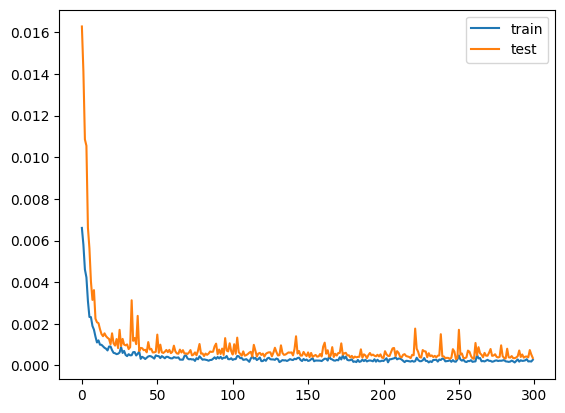

In [202]:
plt.plot(history4.history['loss'], label='train')
plt.plot(history4.history['val_loss'], label='test')
plt.legend()
plt.show()

In [203]:
def recursive_predict(model, initial_sequence, n_steps, future_features, scaler):
    """
    Realiza predicciones recursivas utilizando un modelo de series temporales.
    
    Args:
        model: Modelo entrenado
        initial_sequence: Secuencia inicial de entrada (shape: [sequence_length, n_features])
        n_steps: Número de pasos futuros a predecir
        future_features: Características futuras conocidas
    
    Returns:
        np.array: Array con las predicciones
    """
    predictions = []
    current_sequence = initial_sequence.copy()
    
    for i in range(n_steps):
        # Realizar predicción
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape))[0]
        predictions.append(next_pred)
        
        # Actualizar la secuencia
        current_sequence = np.roll(current_sequence, -1, axis=0)
        
        # Actualizar el último valor con la predicción
        current_sequence[-1, 0] = next_pred
        
        # Actualizar características temporales si están disponibles
        if i < len(future_features):
            current_sequence[-1, 1:] = future_features[i, 1:]  # Mantener todas las características excepto weekly_sales
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [204]:
# Make predictions
initial_sequence = X_test[0]
y_pred4 = recursive_predict(
    model4,
    initial_sequence,
    pred_length,
    scaled_features[train_size:train_size+pred_length],
    scaler
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Users\alexg\AppData\Local\Temp\ipykernel_10208\2867808645.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1, 0] = next_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [205]:
# Métricas
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred4))
mae = mean_absolute_error(y_test_inv, y_pred4)
mape = mean_absolute_percentage_error(y_test_inv, y_pred4)
print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

RMSE: 5554485.258593352, MAE: 4181740.9776666663, MAPE: 0.08466398429153577


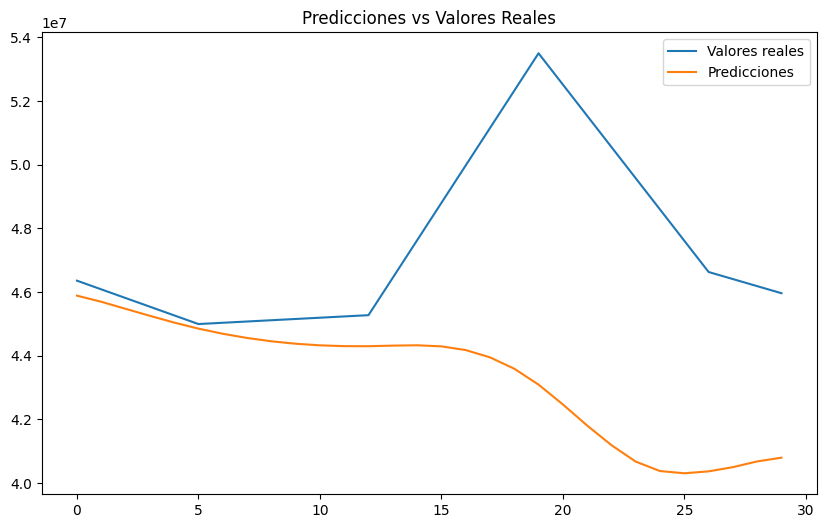

In [206]:
# Gráfico de predicciones vs reales
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Valores reales')
plt.plot(y_pred4, label='Predicciones')
plt.legend()
plt.title("Predicciones vs Valores Reales")
plt.show()

### Quinto Modelo

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [ ]:
DATA_PATH = os.path.join('..', '..', 'data', 'input', 'forecasting')
data = pd.read_csv(os.path.join(DATA_PATH, 'data_processed.csv'))

In [ ]:
def prepare_data(df):
	# Convert weekly data to daily using linear interpolation
	df = df.copy()
	df['Date'] = pd.to_datetime(df['Date'])
	
	# Aggregate sales across all stores and departments
	df = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
	
	# Create daily dates
	daily_dates = pd.date_range(df['Date'].min(), df['Date'].max(), freq='D')
	daily_df = pd.DataFrame({'Date': daily_dates})
	
	# Merge with original data
	daily_df = daily_df.merge(df, on='Date', how='left')
	
	# Interpolate missing values
	daily_df['Weekly_Sales'] = daily_df['Weekly_Sales'].interpolate(method='linear')
	
	# Add time-based features
	# daily_df['DayOfWeek'] = daily_df['Date'].dt.dayofweek
	# daily_df['Month'] = daily_df['Date'].dt.month
	# daily_df['Year'] = daily_df['Date'].dt.year
	# daily_df['DayOfYear'] = daily_df['Date'].dt.dayofyear
	# daily_df['IsWeekend'] = daily_df['DayOfWeek'].isin([5, 6]).astype(int)
	
	return daily_df

In [ ]:
def prepare_features(df, scaler):
	# Create feature matrix
    feature_columns = [
		'Weekly_Sales', 
		# 'DayOfWeek', 'Month', 'Year','DayOfYear', 'IsWeekend'
	]
	
    scaled_features = scaler.transform(df[feature_columns])
	
    return scaled_features

In [ ]:
def create_sequences(data, seq_length=30):
	"""Create sequences without fixed prediction length"""
	X = []
	for i in range(len(data) - seq_length + 1):
		X.append(data[i:(i + seq_length)])
	return np.array(X)

In [ ]:
daily_df = prepare_data(data)
daily_df

,Date,Weekly_Sales
0,2010-02-05,49750875.98
1,2010-02-06,49548865.14
2,2010-02-07,49346854.30
3,2010-02-08,49144843.46
4,2010-02-09,48942832.62
...,...,...
990,2012-10-22,45303273.49
991,2012-10-23,45363550.00
992,2012-10-24,45423826.51
993,2012-10-25,45484103.02


In [ ]:
scaler = MinMaxScaler().fit(daily_df[['Weekly_Sales']])
scaled_features = prepare_features(daily_df, scaler)
scaled_features

array([[0.24558922],
       [0.24070161],
       [0.235814  ],
       [0.23092639],
       [0.22603878],
       [0.22115117],
       [0.21626356],
       [0.21137595],
       [0.21117237],
       [0.2109688 ],
       [0.21076522],
       [0.21056165],
       [0.21035808],
       [0.2101545 ],
       [0.20995093],
       [0.19506262],
       [0.18017432],
       [0.16528601],
       [0.15039771],
       [0.1355094 ],
       [0.1206211 ],
       [0.10573279],
       [0.11576421],
       [0.12579563],
       [0.13582705],
       [0.14585846],
       [0.15588988],
       [0.1659213 ],
       [0.17595272],
       [0.1726834 ],
       [0.16941408],
       [0.16614477],
       [0.16287545],
       [0.15960613],
       [0.15633681],
       [0.1530675 ],
       [0.14982743],
       [0.14658737],
       [0.14334731],
       [0.14010725],
       [0.13686718],
       [0.13362712],
       [0.13038706],
       [0.12743236],
       [0.12447767],
       [0.12152297],
       [0.11856828],
       [0.115

In [ ]:
seq_length = 30
pred_length = 30

In [ ]:
# Create sequences
X = create_sequences(scaled_features, seq_length)
y = scaled_features[seq_length:, 0]

In [ ]:
# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size-pred_length:train_size]

In [207]:
model5 = Sequential([
	Conv1D(filters=64, kernel_size=3, activation='relu',
			input_shape=(X_train.shape[1], X_train.shape[2])),
	MaxPooling1D(pool_size=2),
	Conv1D(filters=32, kernel_size=3, activation='relu'),
	MaxPooling1D(pool_size=2),
	LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(32, return_sequences=False),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
	Dense(1)  # Predict one step at a time
])

model5.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_3\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [208]:
checkpoint = ModelCheckpoint('../../models/forecasting/model5.keras', save_best_only=True)
history5 = model5.fit(
	X_train, y_train,
	epochs=300,
	batch_size=48,
	validation_split=0.2,
	callbacks=[checkpoint],
	verbose=1
)

Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0229 - val_loss: 0.0310
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0092 - val_loss: 0.0310
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0108 - val_loss: 0.0318
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0106 - val_loss: 0.0294
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - val_loss: 0.0309
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0086 - val_loss: 0.0275
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114 - val_loss: 0.0250
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0105 - val_loss: 0.0235
Epoch 9/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0081 - val_loss: 0.0174
Epoch 10/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068 - val_loss: 0.0150
Epoch 11/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0178
Epoch 12/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - 

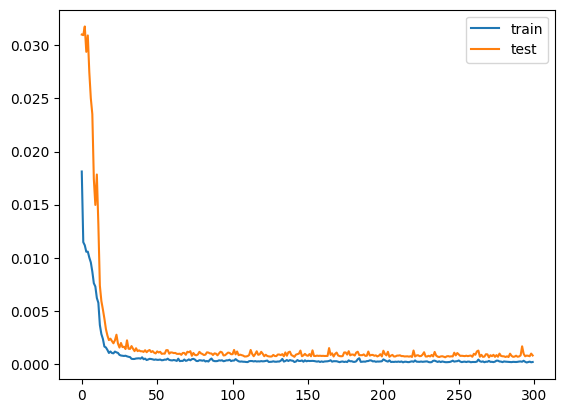

In [209]:
plt.plot(history5.history['loss'], label='train')
plt.plot(history5.history['val_loss'], label='test')
plt.legend()
plt.show()

In [210]:
def recursive_predict(model, initial_sequence, n_steps, future_features, scaler):
    """
    Realiza predicciones recursivas utilizando un modelo de series temporales.
    
    Args:
        model: Modelo entrenado
        initial_sequence: Secuencia inicial de entrada (shape: [sequence_length, n_features])
        n_steps: Número de pasos futuros a predecir
        future_features: Características futuras conocidas
    
    Returns:
        np.array: Array con las predicciones
    """
    predictions = []
    current_sequence = initial_sequence.copy()
    
    for i in range(n_steps):
        # Realizar predicción
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape))[0]
        predictions.append(next_pred)
        
        # Actualizar la secuencia
        current_sequence = np.roll(current_sequence, -1, axis=0)
        
        # Actualizar el último valor con la predicción
        current_sequence[-1, 0] = next_pred
        
        # Actualizar características temporales si están disponibles
        if i < len(future_features):
            current_sequence[-1, 1:] = future_features[i, 1:]  # Mantener todas las características excepto weekly_sales
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [211]:
# Make predictions
initial_sequence = X_test[0]
y_pred5 = recursive_predict(
    model5,
    initial_sequence,
    pred_length,
    scaled_features[train_size:train_size+pred_length],
    scaler
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Users\alexg\AppData\Local\Temp\ipykernel_10208\2867808645.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1, 0] = next_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [212]:
# Métricas
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred5))
mae = mean_absolute_error(y_test_inv, y_pred5)
mape = mean_absolute_percentage_error(y_test_inv, y_pred5)
print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

RMSE: 4396848.624213269, MAE: 3514581.644333333, MAPE: 0.0713543637688554


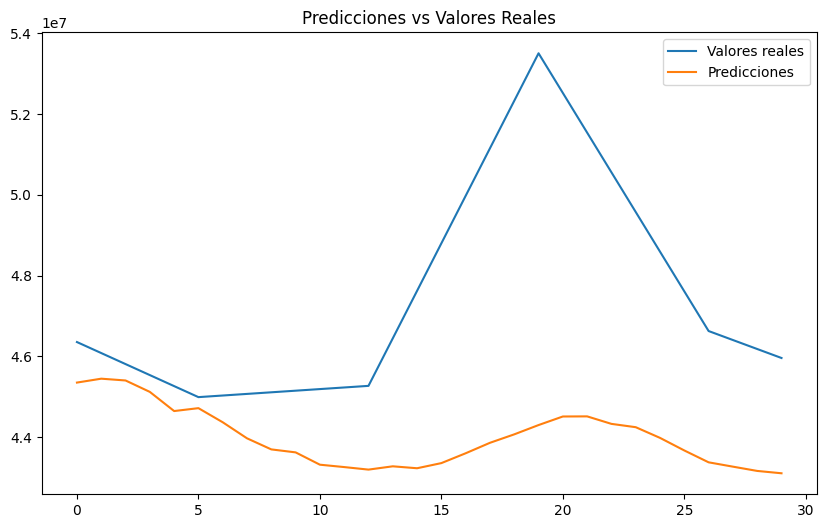

In [213]:
# Gráfico de predicciones vs reales
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Valores reales')
plt.plot(y_pred5, label='Predicciones')
plt.legend()
plt.title("Predicciones vs Valores Reales")
plt.show()

## Evaluación

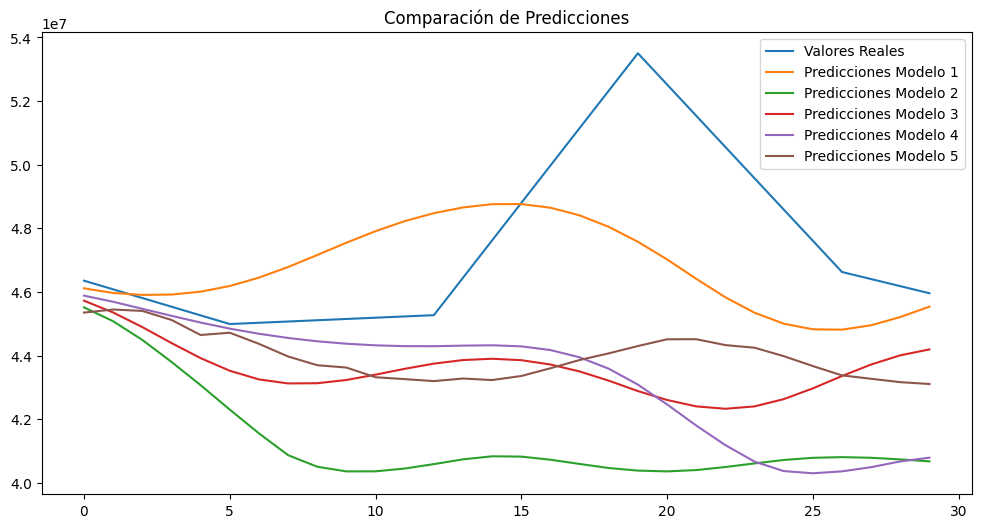

In [214]:
# Comparación de las predicciones de los cinco modelos
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Valores Reales')
plt.plot(y_pred, label='Predicciones Modelo 1')
plt.plot(y_pred2, label='Predicciones Modelo 2')
plt.plot(y_pred3, label='Predicciones Modelo 3')
plt.plot(y_pred4, label='Predicciones Modelo 4')
plt.plot(y_pred5, label='Predicciones Modelo 5')
plt.title('Comparación de Predicciones')
plt.legend()
plt.show()